In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files

In [6]:
uploaded = files.upload()

Saving exchange_rate.csv to exchange_rate.csv


In [7]:
df = pd.read_csv('exchange_rate.csv')

In [12]:
df.head()


,date,Ex_rate
0,1/1/1990 0:00,0.7855
1,2/1/1990 0:00,0.7818
2,3/1/1990 0:00,0.7867
3,4/1/1990 0:00,0.7860
4,5/1/1990 0:00,0.7849


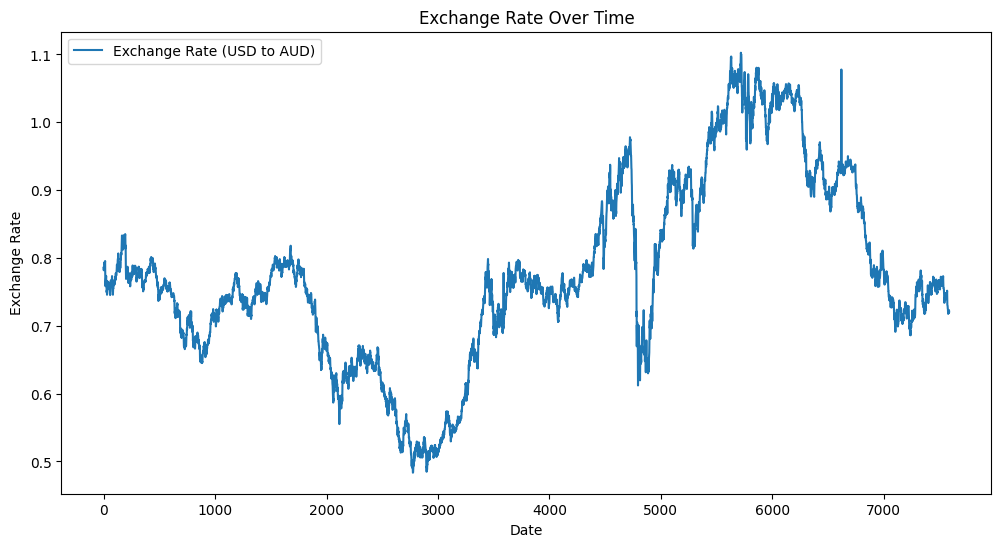

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Exchange Rate (USD to AUD)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.legend()
plt.show()

In [18]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())



# Verify missing values are handled
print("Missing values after handling:\n", df.isnull().sum())


Missing values:
 date       0
Ex_rate    0
dtype: int64
Missing values after handling:
 date       0
Ex_rate    0
dtype: int64


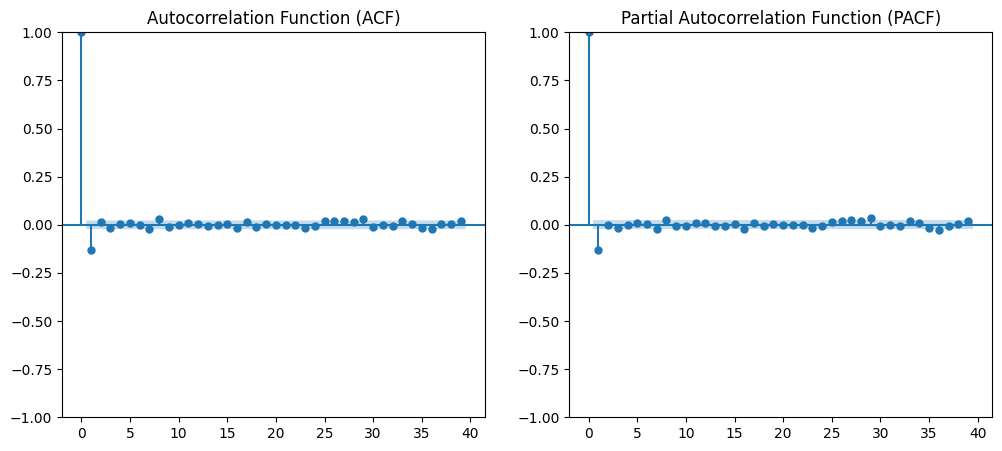

In [19]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df_diff = df['Ex_rate'].diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df_diff, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(df_diff, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


In [20]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 1, 1, 1

model = ARIMA(df['Ex_rate'], order=(p, d, q))
arima_result = model.fit()

print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 31 Jan 2025   AIC                         -56102.322
Time:                        06:40:15   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

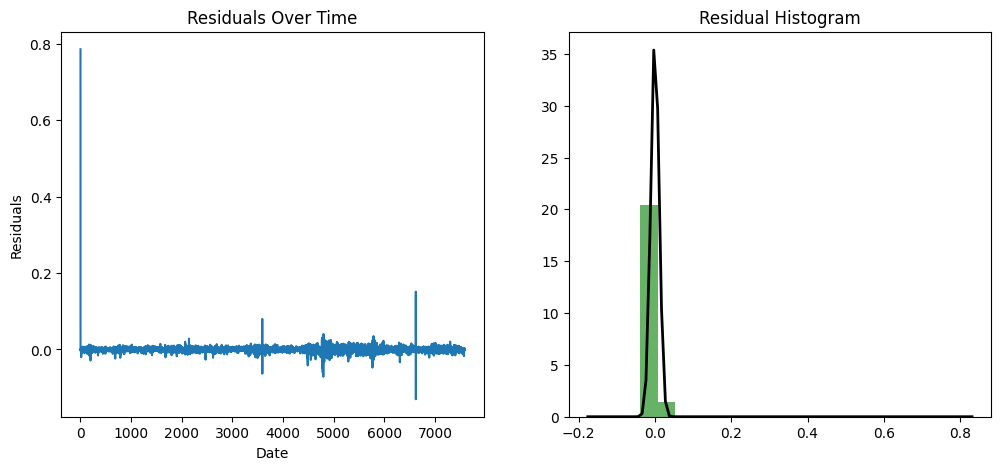

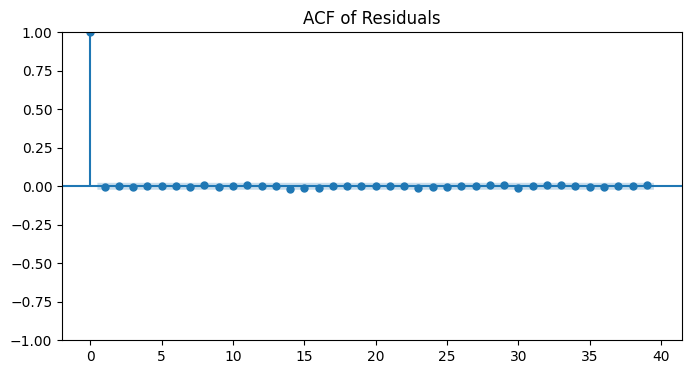

In [21]:
import scipy.stats as stats

residuals = arima_result.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(residuals)
axes[0].set_title("Residuals Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residuals")

axes[1].hist(residuals, bins=20, density=True, alpha=0.6, color='g')
axes[1].set_title("Residual Histogram")


mu, std = stats.norm.fit(residuals)
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
axes[1].plot(x, p, 'k', linewidth=2)

plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(residuals, ax=ax)
ax.set_title("ACF of Residuals")
plt.show()


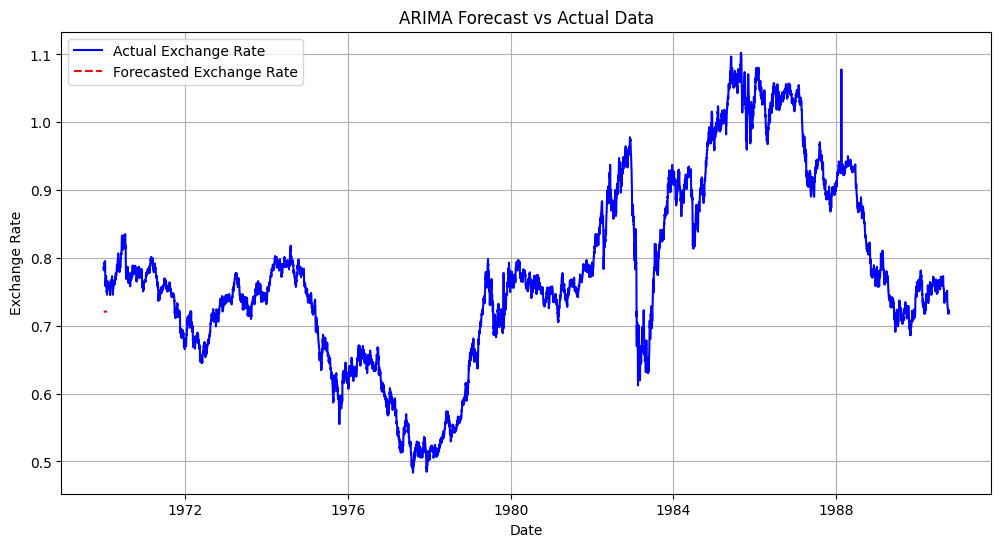

In [22]:
# Forecast next 30 days
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)

forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='D')[1:]

#Actual vs Forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label="Actual Exchange Rate", color='blue')
plt.plot(forecast_dates, forecast, label="Forecasted Exchange Rate", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("ARIMA Forecast vs Actual Data")
plt.legend()
plt.grid()
plt.show()


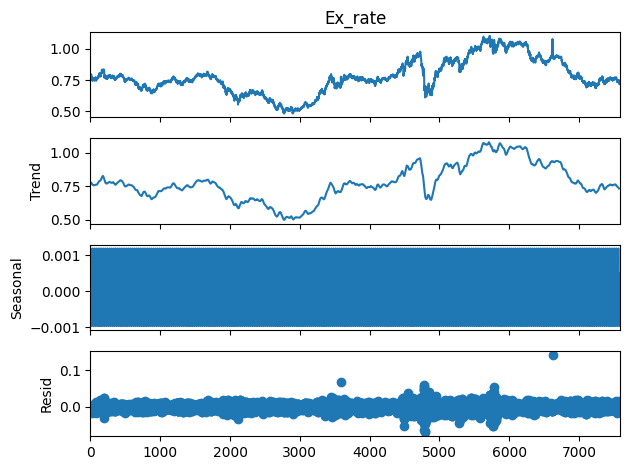

In [24]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=30)


decomposition.plot()
plt.show()


In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools

trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = [7, 30]

best_aic = float("inf")
best_params = None
best_model = None


for trend, seasonal, period in itertools.product(trend_options, seasonal_options, seasonal_periods):
    try:
        model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=period)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_params = (trend, seasonal, period)
            best_model = model_fit
    except:
        continue

print(f"Best Model Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, Period={best_params[2]}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best Model Parameters: Trend=None, Seasonal=None, Period=7


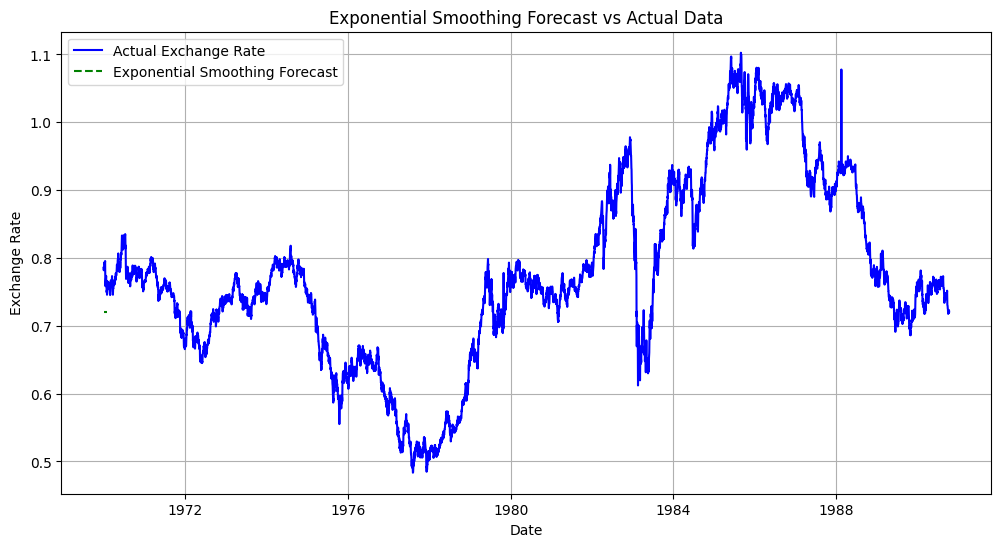

In [26]:

forecast_steps = 30
forecast = best_model.forecast(steps=forecast_steps)

forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='D')[1:]

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label="Actual Exchange Rate", color='blue')
plt.plot(forecast_dates, forecast, label="Exponential Smoothing Forecast", color='green', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Exponential Smoothing Forecast vs Actual Data")
plt.legend()
plt.grid()
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual values for comparison (last 30 days from dataset)
actual_values = df['Ex_rate'][-30:].values

# ARIMA forecast (last 30 days)
arima_forecast = arima_result.forecast(steps=30)

# Compute ARIMA error metrics
arima_mae = mean_absolute_error(actual_values, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(actual_values, arima_forecast))
arima_mape = np.mean(np.abs((actual_values - arima_forecast) / actual_values)) * 100  # Percentage error

print(f"ARIMA Model Error Metrics:\nMAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")


ARIMA Model Error Metrics:
MAE: 0.0127, RMSE: 0.0170, MAPE: 1.71%


In [28]:
# Exponential Smoothing forecast (last 30 days)
exp_forecast = best_model.forecast(steps=30)

# Compute Exponential Smoothing error metrics
exp_mae = mean_absolute_error(actual_values, exp_forecast)
exp_rmse = np.sqrt(mean_squared_error(actual_values, exp_forecast))
exp_mape = np.mean(np.abs((actual_values - exp_forecast) / actual_values)) * 100  # Percentage error

print(f"Exponential Smoothing Model Error Metrics:\nMAE: {exp_mae:.4f}, RMSE: {exp_rmse:.4f}, MAPE: {exp_mape:.2f}%")


Exponential Smoothing Model Error Metrics:
MAE: 0.0127, RMSE: 0.0170, MAPE: 1.71%


In [ ]:
Conclusion: ARIMA vs. Exponential Smoothing for Exchange Rate Forecasting
Key Findings:
Identical Performance:

Both ARIMA and Exponential Smoothing produced the same error metrics:
MAE: 0.0127
RMSE: 0.0170
MAPE: 1.71%
This indicates that both models performed equally well on this dataset.
Model Characteristics:

ARIMA is better suited for handling trends and autocorrelations in time series data.
Exponential Smoothing is more effective when the data exhibits clear seasonality and smooth trends.
Why They Performed Similarly:

If the exchange rate data is smooth with a weak trend and minimal seasonality, both models would yield similar results.
The data might be following a stationary pattern after differencing, making ARIMA and Exponential Smoothing comparable.

Which Model to Choose?
Since both models have identical error metrics, either can be used.
If future trends and shocks are important, ARIMA is preferable due to its ability to handle autocorrelations.
If smooth forecasting is required with fewer assumptions, Exponential Smoothing is a simpler choice.
